In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
def plot_histogram_with_pdf(bars_df, line_df, x_min, x_max, title="Istogramma stimato con PDF sovrapposta", save_path=None):
    """
    Plotta l'istogramma stimato (da un CSV) con la PDF teorica sovrapposta.

    Parameters
    ----------
    bars_df : pd.DataFrame
        DataFrame con colonne: x, estimated_density
    line_df : pd.DataFrame
        DataFrame con colonne: x, pdf
    x_min : float, optional
        Estremo inferiore dell'intervallo da plottare
    x_max : float, optional
        Estremo superiore dell'intervallo da plottare
    title : str, optional
        Titolo del grafico
    save_path : str or None
        Percorso file per salvare il grafico (es. "plot.png", "plot.pdf"). 
        Se None → mostra solo il grafico.
    """

    #  === Taglia al range ===
    bars = bars_df[(bars_df["x"] >= x_min) & (bars_df["x"] <= x_max)].copy()
    line = line_df[(line_df["x"] >= x_min) & (line_df["x"] <= x_max)].copy()

    # Assicurati che ci siano almeno due punti per creare intervalli
    if len(bars) < 2:
        raise ValueError(f"Servono almeno due punti in 'bars_df' nel range [{x_min}, {x_max}] per costruire le barre.")

    # === Prepara intervalli [x_i, x_{i+1}) per le barre ===
    x_start = bars["x"].values[:-1]
    x_end   = bars["x"].values[1:]
    heights = bars["estimated_density"].values[:-1]
    widths  = x_end - x_start

    # === Plot ===
    fig, ax = plt.subplots(figsize=(9,5))

    # Barre (istogramma stimato)
    ax.bar(x_start, heights, width=widths, align="edge",
           edgecolor="black", alpha=0.7, label="Estimated density (bins)")

    # Linea (pdf teorica)
    ax.plot(line["x"].values, line["pdf"].values, linewidth=2, label="PDF (line)")

    ax.set_xlim(x_min, x_max)
    ax.set_xlabel("x")
    ax.set_ylabel("Density")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    # --- Salvataggio o visualizzazione ---
    if save_path:
        fig.savefig(save_path, dpi=300)   # alta qualità
        plt.close(fig)                    # chiudi la figura per non aprirla a schermo
    else:
        plt.show()

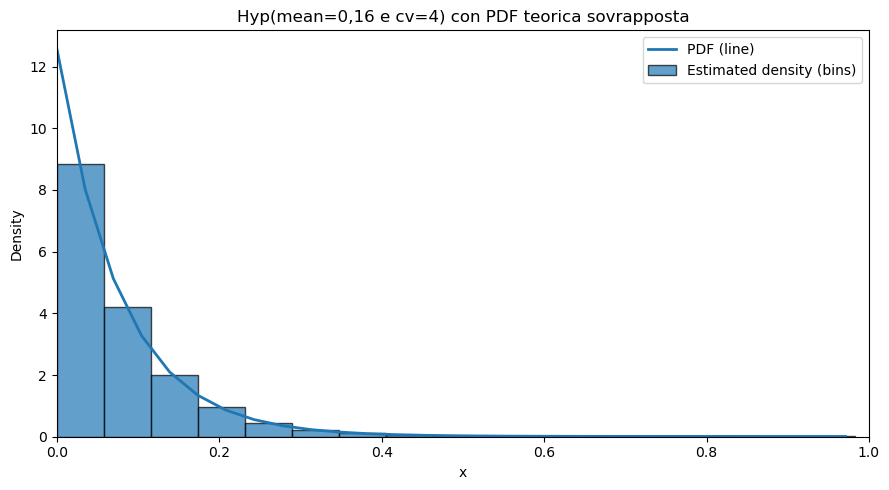

In [19]:
# Iperesponenziale degli arrivi
bars = pd.read_csv("csv/hyperexponential_histogram.csv")
line = pd.read_csv("csv/hyperexponential_theoretical.csv")

plot_histogram_with_pdf(bars, line, x_min=0, x_max=1,
    title="Hyp(mean=0,16 e cv=4) con PDF teorica sovrapposta")

In [37]:
def plot_actual_si_step(df, time_col="Time", server_col="ServerID", si_col="ActualSI",
                        title="Andamento ActualSI per Server (step)", marker=None,
                        linewidth=1.0, save_path=None):
    """
    Plotta l'andamento di ActualSI per ciascun server nel tempo con linee a gradini costanti.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame con almeno le colonne [time_col, server_col, si_col].
    time_col : str
        Nome della colonna con i tempi (asse X).
    server_col : str
        Nome della colonna con l'ID del server (usato per separare le curve).
    si_col : str
        Nome della colonna con i valori di ActualSI (asse Y).
    title : str
        Titolo del grafico.
    marker : str or None
        Marker per i punti (es. "o"). Se None non vengono usati marker.
    linewidth : float
        Spessore della linea (default = 1.0).
    save_path : str or None
        Percorso file per salvare il grafico (es. "plot.png"). Se None, mostra il grafico.
    """

    fig, ax = plt.subplots(figsize=(9,5))

    # Disegna una linea "a gradini" per ogni server
    for server_id, group in df.groupby(server_col):
        label = "Spike" if server_id == -1 else f"Server {server_id}"
        ax.step(group[time_col], group[si_col],
                where="post", linewidth=linewidth, marker=marker,
                label=label)

    ax.set_xlabel(time_col)
    ax.set_ylabel(si_col)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=300)
        plt.close(fig)
    else:
        plt.show()

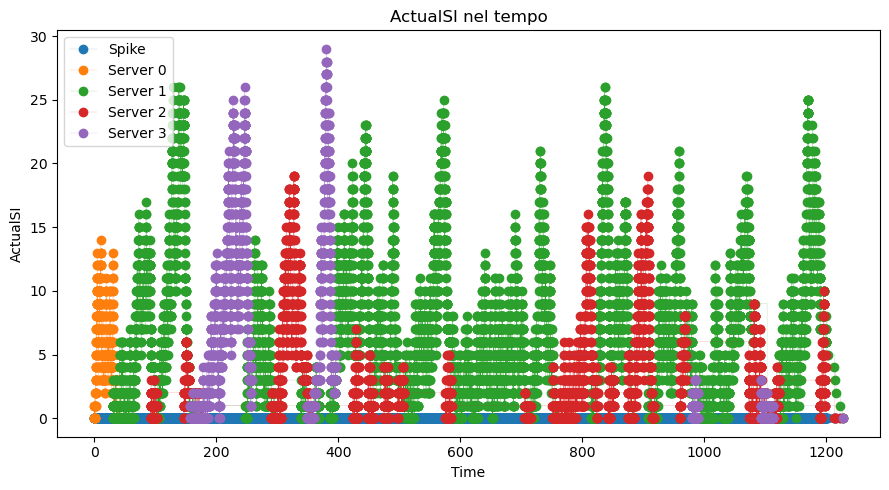

In [45]:
df = pd.read_csv("csv/Serverstats123456789rep0.csv")

plot_actual_si_step(df,
                    time_col="Time",
                    server_col="ServerID",
                    si_col="ActualSI",
                    title="ActualSI nel tempo",
                    marker="o",
                    linewidth=0.1,   # 🔥 linea più fine
                    save_path=None)  # None → mostra, altrimenti "si_plot.png"

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, sqrt

def plot_actual_si(
    df,
    time_col="Time",
    server_col="ServerID",
    si_col="ActualSI",
    title="ActualSI nel tempo",
    linewidth=0.8,
    separate_panels=True,   # <- un subplot per server (più leggibile)
    max_cols=3,
    save_path=None
):
    # ordina per tempo
    df = df.sort_values(time_col)

    groups = list(df.groupby(server_col))
    n = len(groups)

    if separate_panels and n > 1:
        cols = min(max_cols, n)
        rows = ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 2.8*rows), sharex=True, sharey=True)
        axes = axes.flatten() if n > 1 else [axes]

        for i, (sid, g) in enumerate(groups):
            ax = axes[i]
            label = "Spike Server" if sid == -1 else f"Server {sid}"
            ax.step(g[time_col], g[si_col], where="post", linewidth=linewidth)
            ax.set_title(label, fontsize=11)
            ax.set_xlabel(time_col)
            ax.set_ylabel(si_col)
            ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.5)

        # nascondi assi vuoti se n < rows*cols
        for j in range(i+1, rows*cols):
            fig.delaxes(axes[j])

        fig.suptitle(title, fontsize=13)
        fig.tight_layout(rect=[0, 0, 1, 0.96])

    else:
        # tutto in un unico grafico, linee a gradini sottili e leggenda
        fig, ax = plt.subplots(figsize=(10, 4))
        for sid, g in groups:
            label = "Spike Server" if sid == -1 else f"Server {sid}"
            ax.step(g[time_col], g[si_col], where="post", linewidth=linewidth, label=label)
        ax.set_xlabel(time_col)
        ax.set_ylabel(si_col)
        ax.set_title(title)
        ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.5)
        ax.legend(ncol=2, frameon=True)
        plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        plt.close()
    else:
        plt.show()


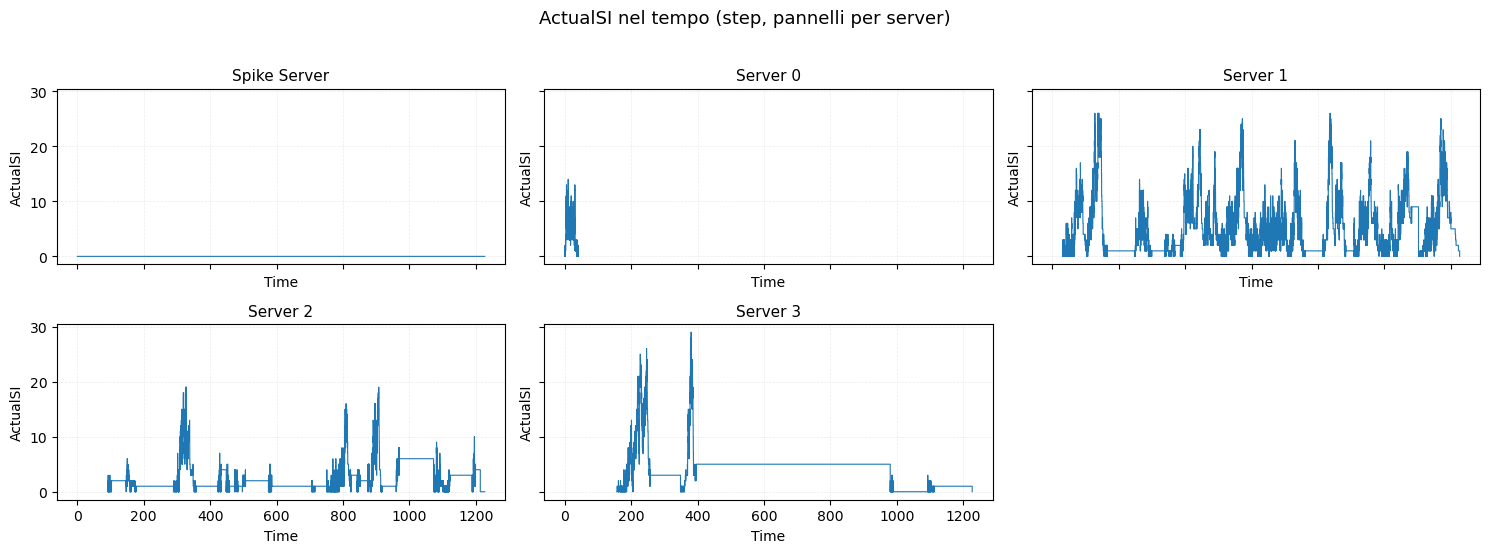

In [44]:
plot_actual_si(df,
    title="ActualSI nel tempo (step, pannelli per server)",
    linewidth=0.8,
    separate_panels=True,   # ← attiva i sottografi
    max_cols=3,
    save_path=None
)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _to_float_with_comma(x):
    # converte "0,037" -> 0.037 (gestisce stringhe con/ senza doppi apici)
    if isinstance(x, str):
        return float(x.replace('"','').replace(',', '.'))
    return float(x)

def verify_and_plot_ps(
    csv_path,
    server_id=None,              # se vuoi filtrare un singolo server (es. 0); None = tutti
    time_cols=("Arrival","Departure"),
    size_col="OriginalSize",
    jobid_col="JobID",
    server_col="AssignedServerID",
    tol_abs=1e-6, tol_rel=1e-3,
    make_plots=True
):
    # --- 1) Leggi CSV con virgole decimali ---
    parse_cols = [jobid_col, *time_cols, "ResponseTime", size_col]
    if server_col is not None:
        parse_cols.append(server_col)

    df = pd.read_csv(csv_path, usecols=parse_cols,
                     converters={time_cols[0]: _to_float_with_comma,
                                 time_cols[1]: _to_float_with_comma,
                                 "ResponseTime": _to_float_with_comma,
                                 size_col: _to_float_with_comma})

    # eventuale filtro per server
    if server_id is not None and server_col in df.columns:
        df = df[df[server_col] == server_id].copy()

    # ordina per tempo di arrivo (non obbligatorio ma utile)
    a_col, d_col = time_cols
    df.sort_values(by=[a_col, d_col], inplace=True, ignore_index=True)

    # sanity check: ResponseTime ~ Departure-Arrival
    rt_err = (df[d_col] - df[a_col]) - df["ResponseTime"]
    ok_rt = np.allclose(rt_err.values, 0.0, atol=tol_abs, rtol=tol_rel)

    # --- 2) Costruisci gli "eventi" per n(t) ---
    # evento +1 all'arrivo, -1 alla partenza (right-open, left-closed: [t_i, t_{i+1}))
    events = []
    for _, r in df.iterrows():
        events.append((r[a_col], +1))
        events.append((r[d_col], -1))
    events.sort(key=lambda x: (x[0], -x[1]))  # a parità di tempo: esegui le partenze (-1) dopo gli arrivi (+1) se vuoi [t, t_next)

    # segmenti [t_i, t_{i+1}) con n(t) costante
    times = sorted(set([t for t,_ in events]))
    # assicura i bordi
    if len(times) < 2:
        raise ValueError("Servono almeno due eventi per costruire n(t).")
    # scan line per n(t)
    n_of_t = []
    cur = 0
    idx = 0
    # precompute evento per tempo
    ev_by_time = {}
    for t, delta in events:
        ev_by_time.setdefault(t, 0)
        ev_by_time[t] += delta
    for i in range(len(times)-1):
        t = times[i]
        cur += ev_by_time.get(t, 0)
        n_of_t.append((times[i], times[i+1], cur))  # [start, end, n]

    # --- 3) Integra servizio per job: sum_{segments in [a,d)} dt / n ---
    accumulated = []
    for _, r in df.iterrows():
        a, d = r[a_col], r[d_col]
        svc = 0.0
        for (s, e, n) in n_of_t:
            if n <= 0:  # nessun job; salta
                continue
            # overlap con [a,d)
            start = max(a, s)
            end   = min(d, e)
            if end > start:
                svc += (end - start) / n
        accumulated.append(svc)

    df["PS_Service"] = accumulated
    df["Size_Error"] = df["PS_Service"] - df[size_col]
    df["AbsErr"] = df["Size_Error"].abs()
    df["RelErr"] = df["AbsErr"] / df[size_col].replace(0, np.nan)

    ok_ps = (df["AbsErr"] <= tol_abs) | (df["RelErr"] <= tol_rel)
    all_ok = bool(ok_ps.fillna(True).all())

    # --- 4) Report sintetico ---
    report = {
        "jobs": len(df),
        "ok_response_time": ok_rt,
        "ok_ps_all": all_ok,
        "max_abs_err": float(df["AbsErr"].max()),
        "p95_abs_err": float(df["AbsErr"].quantile(0.95)),
        "max_rel_err": float(df["RelErr"].replace([np.inf, np.nan], 0).max()),
    }

    # --- 5) Plot (opzionale) ---
    if make_plots:
        # 5a) n(t) step plot
        fig, ax = plt.subplots(figsize=(10, 3))
        # costruisci vettori per step
        xs = []
        ys = []
        for s, e, n in n_of_t:
            xs += [s, e]
            ys += [n, n]
        ax.step(xs, ys, where="post", linewidth=1.0)
        ax.set_xlabel("Time")
        ax.set_ylabel("Concurrent jobs n(t)")
        ax.set_title("Concorrenza (Processor Sharing) nel tempo")
        ax.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()

        # 5b) Confronto OriginalSize vs PS_Service
        fig2, ax2 = plt.subplots(figsize=(10, max(3, len(df)*0.2)))
        # ordina per departure
        dff = df.sort_values(d_col)
        y = np.arange(len(dff))
        ax2.barh(y-0.15, dff[size_col].values, height=0.3, label="OriginalSize")
        ax2.barh(y+0.15, dff["PS_Service"].values, height=0.3, label="PS accumulated")
        ax2.set_yticks(y, [f"Job {int(j)}" for j in dff[jobid_col]])
        ax2.set_xlabel("Service")
        ax2.set_title("Verifica PS per job")
        ax2.legend()
        ax2.grid(True, axis="x", linestyle="--", alpha=0.3)
        plt.tight_layout()

        plt.show()

    return df, report

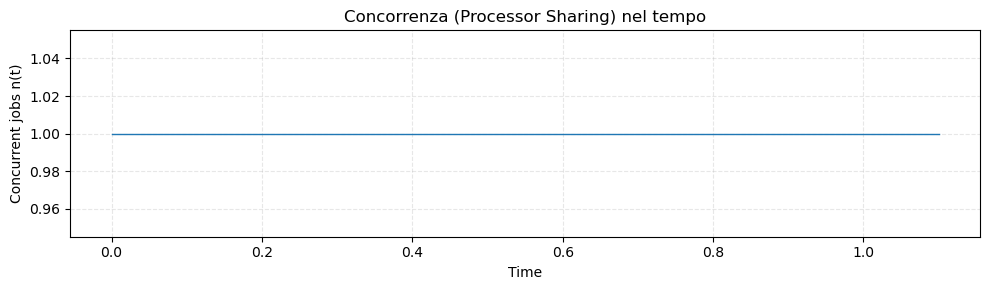

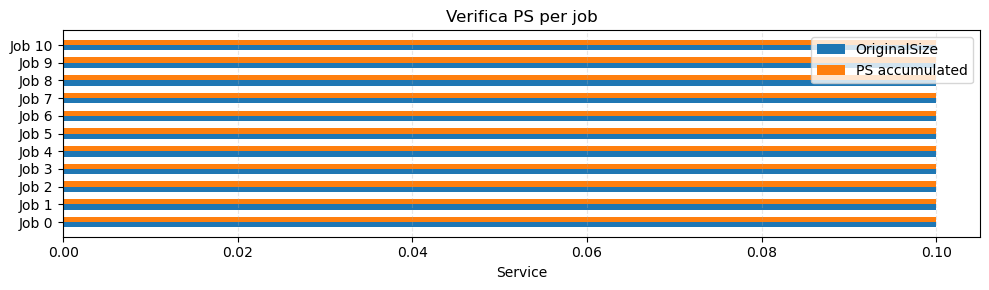

{'jobs': 11, 'ok_response_time': True, 'ok_ps_all': True, 'max_abs_err': 8.326672684688674e-17, 'p95_abs_err': 8.326672684688674e-17, 'max_rel_err': 8.326672684688674e-16}


In [9]:
df_report, summary = verify_and_plot_ps("csv/Jobstats123456789rep0.csv", server_id=0)
print(summary)

In [5]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_remaining_times(
    csv_path,
    time_col="Time",
    dep_list_col="ProxDepartureofAllJobs",
    title_prefix="Tempo rimanente",
    save_path=None
):
    """
    Dal CSV con colonna 'ProxDepartureofAllJobs' = lista di departure assolute per i job attivi,
    calcola e plotta:
      - W(t) = somma dei tempi rimanenti per evento (linea a gradini)
      - punti dei tempi rimanenti per ciascun job ad ogni evento

    Parameters
    ----------
    csv_path : str
        Path al CSV.
    time_col : str
        Colonna con i tempi degli eventi (x).
    dep_list_col : str
        Colonna con stringhe tipo "[1.23, 2.34, ...]" (departure assolute dei job attivi).
    title_prefix : str
        Prefisso del titolo dei grafici.
    save_path : str or None
        Se valorizzato, salva i grafici in "<save_path>_work.png" e "<save_path>_points.png".
    """

    # --- carica e ordina ---
    df = pd.read_csv(csv_path)
    df = df.sort_values(time_col).reset_index(drop=True)

    # --- parse delle liste e calcolo tempi rimanenti ---
    rem_lists = []
    totals = []
    counts = []
    times = df[time_col].values

    for t, s in zip(df[time_col], df[dep_list_col]):
        # s è una stringa "[]", "[a, b, ...]"; converti in lista di float
        dep_list = ast.literal_eval(s)
        rem = [max(0.0, d - t) for d in dep_list]   # tempo rimanente non negativo
        rem_lists.append(rem)
        totals.append(float(np.sum(rem)))
        counts.append(len(rem))

    # --- 1) Backlog totale W(t) (step) ---
    # costruisco step 'post'
    xs, ys = [], []
    for i in range(len(times)):
        x0 = times[i]
        xs.append(x0)
        ys.append(totals[i])
        # prossimo punto per mantenere il gradino fino al tempo successivo
        if i + 1 < len(times):
            xs.append(times[i+1])
            ys.append(totals[i])

    fig1, ax1 = plt.subplots(figsize=(10, 3.2))
    ax1.step(xs, ys, where="post", linewidth=1.0)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Σ remaining time  W(t)")
    ax1.set_title(f"{title_prefix} — backlog totale W(t)")
    ax1.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()

    if save_path:
        fig1.savefig(f"{save_path}_work.png", dpi=300)

    # --- 2) Punti: tempi rimanenti dei singoli job per evento ---
    # creo due vettori "long" per scatter
    scatter_x = []
    scatter_y = []
    for t, rem in zip(times, rem_lists):
        scatter_x.extend([t]*len(rem))
        scatter_y.extend(rem)

    fig2, ax2 = plt.subplots(figsize=(10, 4))
    ax2.scatter(scatter_x, scatter_y, s=12, alpha=0.6)  # puntini piccoli
    ax2.set_xlabel("Time (eventi)")
    ax2.set_ylabel("Tempo rimanente per job")
    ax2.set_title(f"{title_prefix} — distribuzione per evento")
    ax2.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()

    if save_path:
        fig2.savefig(f"{save_path}_points.png", dpi=300)
        plt.close(fig1)
        plt.close(fig2)
    else:
        plt.show()

    # opzionale: ritorna anche i dati calcolati
    out = pd.DataFrame({
        "Time": times,
        "TotalRemaining": totals,
        "NumJobs": counts
    })
    return out, rem_lists

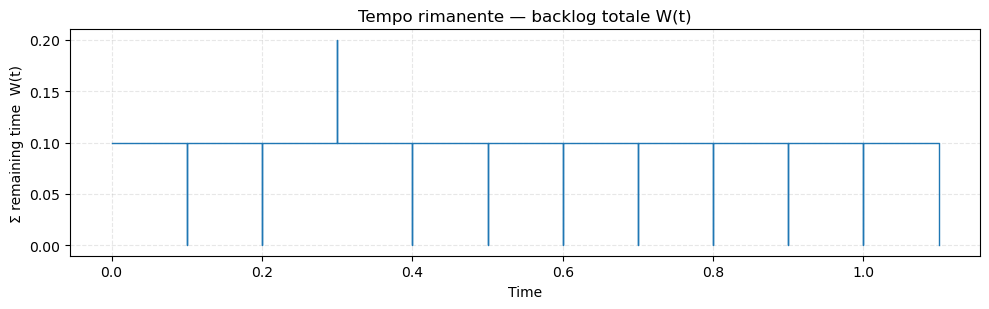

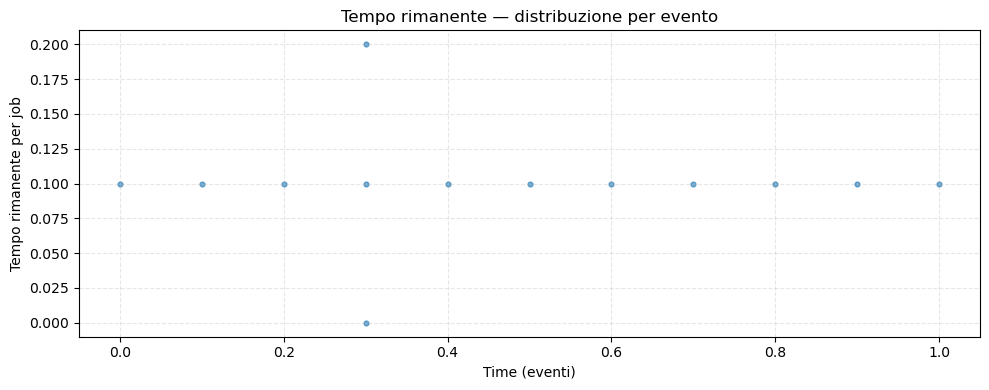

In [10]:
out, rem_lists = plot_remaining_times("csv/Departures123456789rep0.csv", save_path=None)


In [12]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

def check_ps_server(csv_path, time_col="Time",
                    rem_col="RemainingSizeOfAllJobs",
                    numjobs_col="NumJobs",
                    tol=1e-8):
    df = pd.read_csv(csv_path)
    df = df.sort_values(time_col).reset_index(drop=True)

    times = df[time_col].values
    rem_lists = [ast.literal_eval(s) for s in df[rem_col]]

    ok_all = True
    errors = []

    # Verifica PS tra eventi consecutivi
    for i in range(len(times) - 1):
        t0, t1 = times[i], times[i+1]
        dt = t1 - t0
        n = df.loc[i, numjobs_col]
        if n == 0:
            continue

        # remaining attuale
        rem0 = rem_lists[i]
        rem1 = rem_lists[i+1]

        # check somma
        sum0 = sum(rem0)
        sum1 = sum(rem1)
        expected_sum1 = sum0 - dt
        if abs(sum1 - expected_sum1) > tol:
            ok_all = False
            errors.append((i, f"Errore somma: atteso {expected_sum1}, trovato {sum1}"))

        # check singoli job: decremento uniforme
        if len(rem0) == n and len(rem1) <= n:
            # i job comuni devono diminuire di dt/n
            dec = dt / n
            for r0 in rem0:
                # trova il match in rem1 (approssimato)
                candidates = [r1 for r1 in rem1 if abs((r0 - dec) - r1) < tol]
                if not candidates and r0 - dec > tol:  # se non è un job terminato
                    ok_all = False
                    errors.append((i, f"Job non trovato: partiva da {r0}, atteso {r0-dec}"))

    # --- grafico backlog totale ---
    totals = [sum(lst) for lst in rem_lists]
    fig, ax = plt.subplots(figsize=(10,4))
    ax.step(times, totals, where="post")
    ax.set_xlabel("Time")
    ax.set_ylabel("Total remaining size")
    ax.set_title("Backlog totale nel server (Processor Sharing check)")
    plt.tight_layout()
    plt.show()

    return ok_all, errors

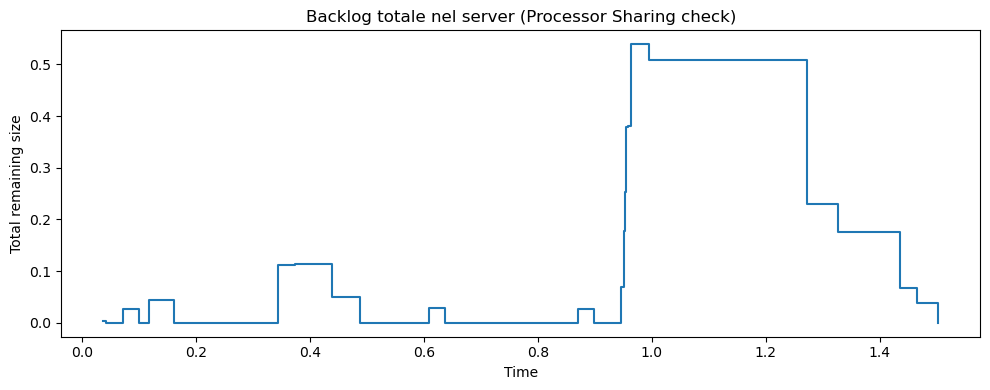

Rispetta Processor Sharing: False
Errore: (6, 'Errore somma: atteso 0.08200109548515316, trovato 0.11453176271301177')
Errore: (16, 'Errore somma: atteso 0.06424118177920557, trovato 0.17829559883043372')
Errore: (17, 'Errore somma: atteso 0.17665511685492846, trovato 0.25390075750310165')
Errore: (18, 'Errore somma: atteso 0.2515681060078497, trovato 0.37886509036682997')
Errore: (19, 'Errore somma: atteso 0.37453340633580995, trovato 0.38069708341895')
Errore: (20, 'Errore somma: atteso 0.3758528072968416, trovato 0.5388824698010344')


In [14]:
# Esempio di utilizzo
ok, errs = check_ps_server("csv/Departures123456789rep0.csv")
print("Rispetta Processor Sharing:", ok)
for e in errs:
    print("Errore:", e)